## Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 0. Import Packages

In [1]:
#importing some useful packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from numpy.linalg import inv
import math
import glob
%matplotlib inline

%load_ext autoreload
%autoreload 2

## 1. Camera Calibration

In [2]:
nx = 9
ny = 6
# Read images
fnames = glob.glob('camera_cal/calibration*.jpg')

#object points and image points
objpoints = []
imgpoints = []

# forming object points like (0,0,0), (1,0,0)
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

ctr =0
#iteration
for fname in fnames:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #find the corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        ctr +=1
        
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

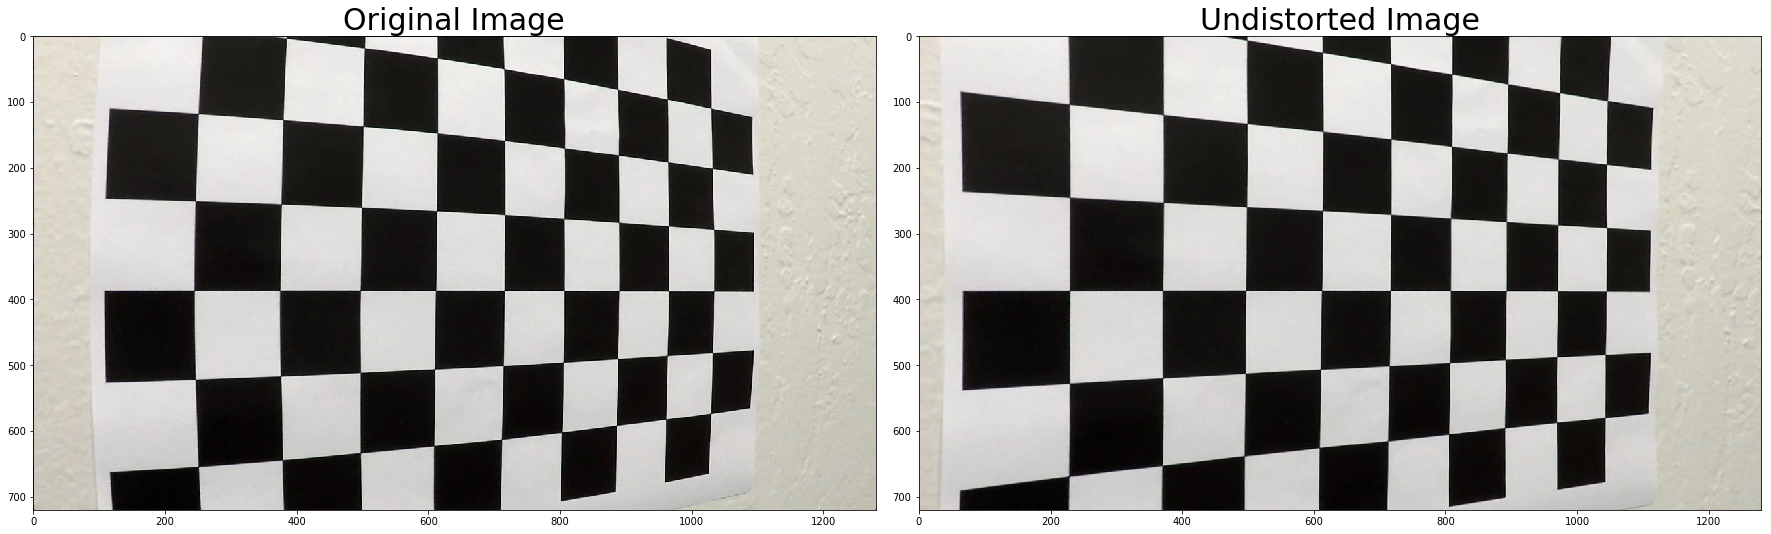

In [3]:
idx = 5
img = mpimg.imread('camera_cal/calibration'+str(idx)+'.jpg')
dst =  cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Distortion Correction

In [4]:
fnames = glob.glob('test_images/*.jpg')
imgs_raw = []
imgs_undist = [] 
print('list of the files:')
i = 0
for fname in fnames:
    img_raw = mpimg.imread(fname)
    imgs_raw.append(img_raw)
    imgs_undist.append(cal_undistort(img_raw, objpoints, imgpoints))
    print(str(i)+': '+fname)
    i +=1


list of the files:
0: test_images/test2.jpg
1: test_images/straight_lines2.jpg
2: test_images/test6.jpg
3: test_images/test3.jpg
4: test_images/test8.jpg
5: test_images/test9.jpg
6: test_images/straight_lines1.jpg
7: test_images/test1.jpg
8: test_images/test4.jpg
9: test_images/test5.jpg
10: test_images/test7.jpg


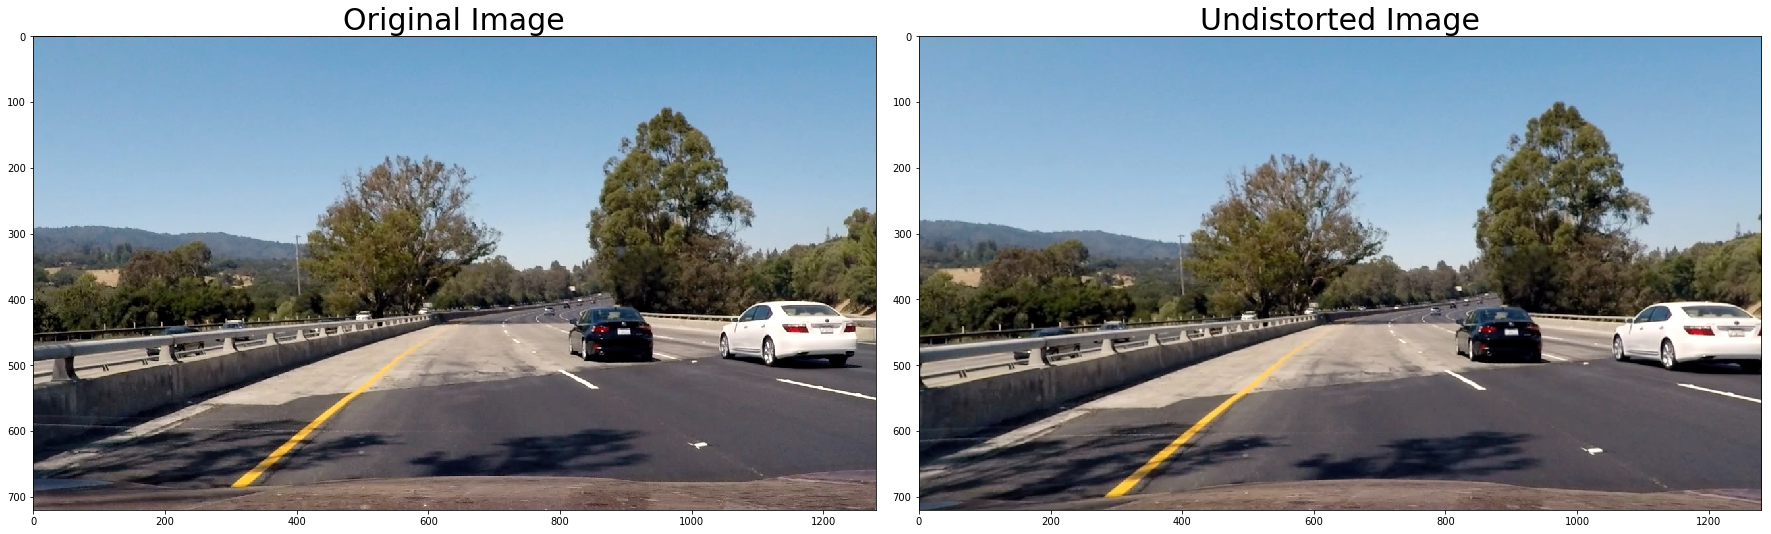

In [5]:
idx = 8
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imgs_raw[idx])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(imgs_undist[idx])
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Gradient and Color

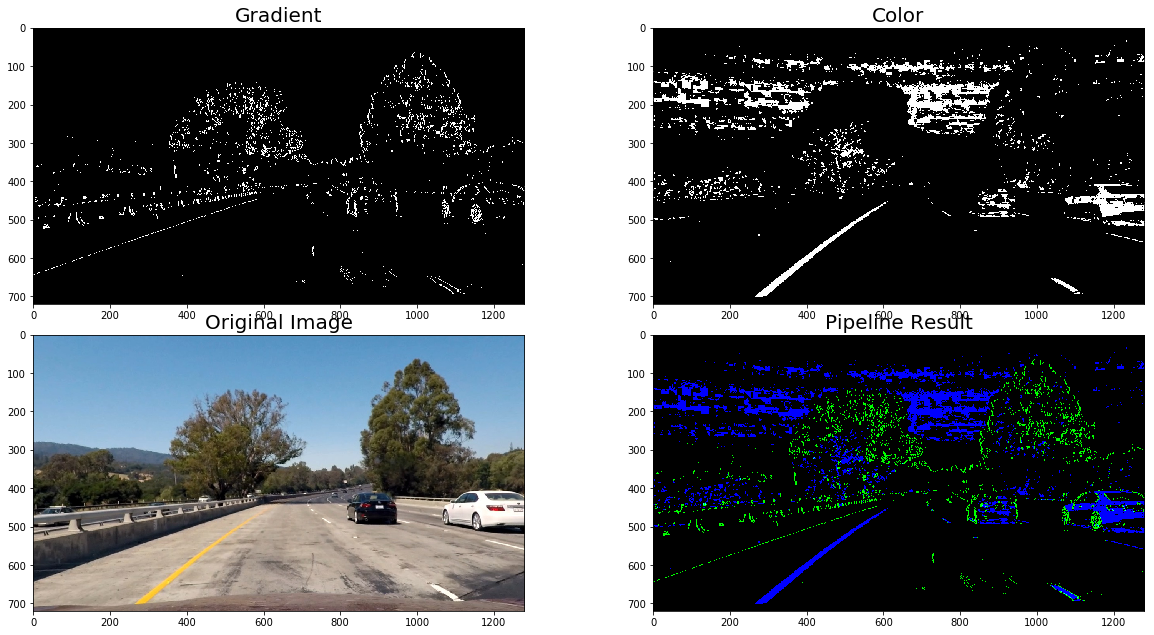

In [6]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(130, 255), sx_thresh=(35, 150)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary.astype(np.uint8), combined_binary
    
idx = 7
result,img_combined = pipeline(imgs_undist[idx])

# Plot the result
f, axes = plt.subplots(2, 2, figsize=(24, 9))
axes = axes.ravel()
f.tight_layout()

axes[0].imshow(result[:,:,1],cmap='gray')
axes[0].set_title('Gradient', fontsize=20)
axes[1].imshow(result[:,:,2],cmap='gray')
axes[1].set_title('Color', fontsize=20)
axes[2].imshow(imgs_undist[idx])
axes[2].set_title('Original Image', fontsize=20)
axes[3].imshow(result)
axes[3].set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=0.7, top=0.9, bottom=0.0)

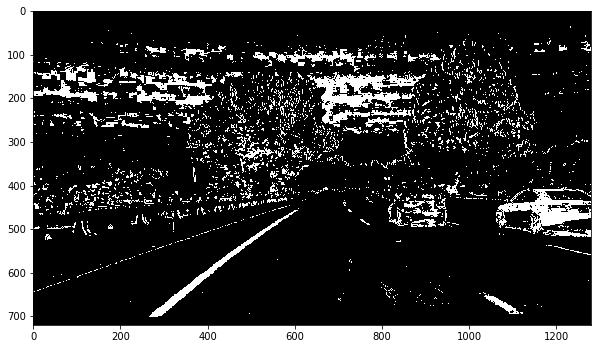

In [7]:
plt.imshow(img_combined,cmap='gray')
plt.gcf().set_size_inches(10, 8)

### Create a batch of binary images

In [8]:
imgs_combined = []
for i in range(len(imgs_undist)):
    _, img_combined = pipeline(imgs_undist[i])
    imgs_combined.append(img_combined)

## 4.  Perspective Transform

### Detecting Src points 

In [9]:
idx = 1
down = 690
up = 455

s1 = [np.where(imgs_combined[idx][down-1,:] == 1)[0][0]+1,down]
s4 = [np.where(imgs_combined[idx][down-1,:] == 1)[0][-1]+1,down]
s2 = [np.where(imgs_combined[idx][up-1,550:720] == 1)[0][0]+551,up]
s3 = [np.where(imgs_combined[idx][up-1,550:720] == 1)[0][-1]+548,up]
src = np.float32([s1,s2,s3,s4])

In [10]:
s1 = [207,720]
s2 = [586,455]
s3 = [698,455]
s4 = [1127,720]
src = np.float32([s1,s2,s3,s4])

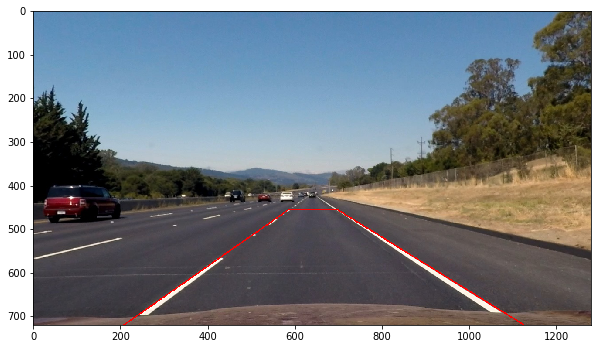

In [11]:
idx = 1
img_pre = np.copy(imgs_undist[idx])

def draw_masks(img, src, color=[255, 0, 0], thickness=2):
    for i in range(len(src)):
        x1, y1 = src[i]
        x2, y2 = src[(i+1)%len(src)]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
#src = np.float32([[190,720],[608,440],[670,440],[1125,720]])


img_draw = np.copy(img_pre)
draw_masks(img_draw,src)
plt.gcf().set_size_inches(10, 8)
plt.imshow(img_draw)

### Dst points

In [12]:
side_offset = 160
dst = np.float32([[src[0,0]+side_offset,720],[src[0,0]+side_offset,0],[src[3,0]-side_offset,0],[src[3,0]-side_offset,720]])
dst

array([[ 367.,  720.],
       [ 367.,    0.],
       [ 967.,    0.],
       [ 967.,  720.]], dtype=float32)

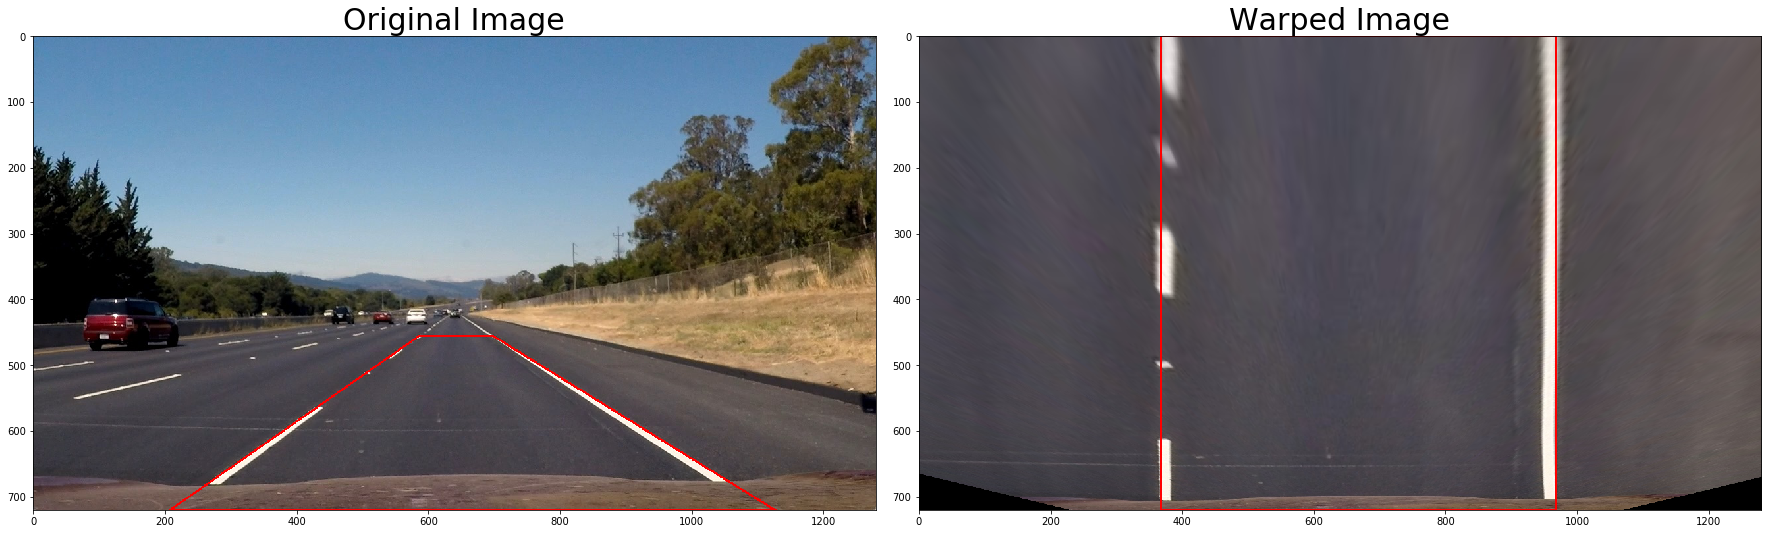

In [13]:
M = cv2.getPerspectiveTransform(src, dst)

img_pre = np.copy(imgs_undist[idx])
img_size = (img_pre.shape[1],img_pre.shape[0])
img_warped = cv2.warpPerspective(img_pre, M,img_size,flags=cv2.INTER_NEAREST)
img_draw = np.copy(img_warped) 
draw_masks(img_draw,dst,thickness=2)


img_pre = np.copy(imgs_raw[idx])
img_size = (img_pre.shape[1],img_pre.shape[0])
img_warped = cv2.warpPerspective(img_pre, M,img_size)
img_draw = np.copy(img_warped)
draw_masks(img_draw,dst,thickness=2)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
draw_masks(img_pre,src,thickness=2)
ax1.imshow(img_pre)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_draw)
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Sliding Window and Histogram

In [14]:
idx = 7
img_combined_warped = cv2.warpPerspective(imgs_combined[idx], M,img_size,flags=cv2.INTER_NEAREST)
# plt.gcf().set_size_inches(10, 8)
# # plt.imshow(img_combined_warped,cmap='gray')

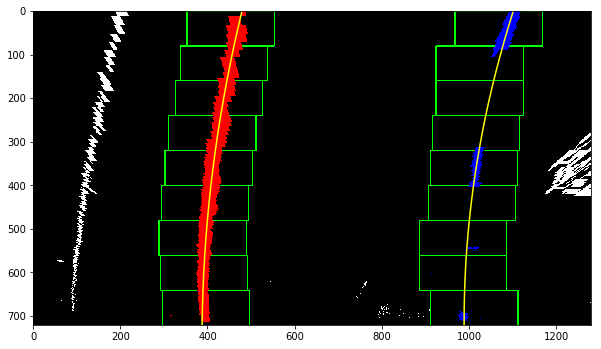

In [15]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = np.copy(img_combined_warped)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 



# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# -----------------Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.gcf().set_size_inches(10, 8)

### Skipping the window searching

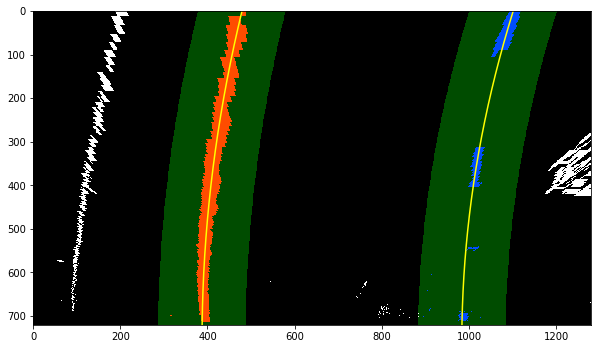

In [16]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.gcf().set_size_inches(10, 8)

## 6. Measuring Curvature

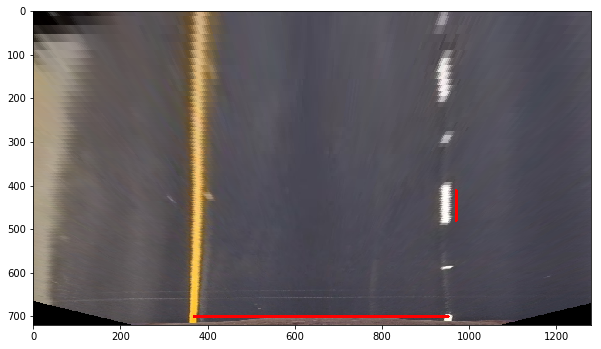

In [20]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = inv(M)
img_pre = np.copy(imgs_undist[6])

img_size = (img_pre.shape[1],img_pre.shape[0])
img_warped = cv2.warpPerspective(img_pre, M,img_size,flags=cv2.INTER_NEAREST)
img_draw = np.copy(img_warped)
width_px = 623
height_px = 70
draw_masks(img_draw,[[369,700],[329+width_px,700]],thickness=5)
draw_masks(img_draw,[[970,410],[970,410+height_px]],thickness=5)
plt.gcf().set_size_inches(10, 8)
plt.imshow(img_draw)

Curvature: left 966 m, right 759 m
Vehicle is -0.27 m left of center


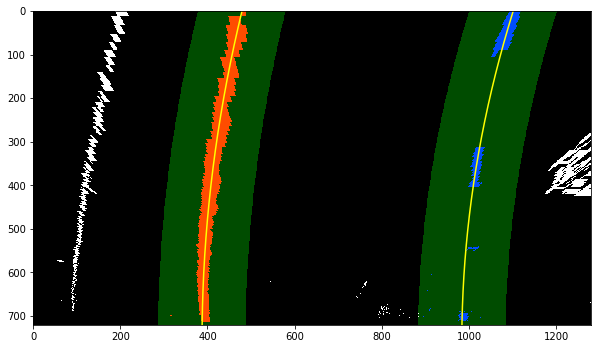

In [21]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 3/height_px # meters per pixel in y dimension
xm_per_pix = 3.7/width_px # meters per pixel in x dimension

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
y_eval_m = 719 * ym_per_pix

diff_m =  (right_fitx - left_fitx)*xm_per_pix

left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_m + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad= ((1 + (2*right_fit_cr[0]*y_eval_m + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
left_pos = left_fit_cr[0]*y_eval_m**2 + left_fit_cr[1]*y_eval_m + left_fit_cr[2]
right_pos = right_fit_cr[0]*y_eval_m**2 + right_fit_cr[1]*y_eval_m + right_fit_cr[2]
line_var = np.var(diff_m)
line_mean = np.mean(diff_m)
line_ratio = np.abs(np.log10(left_curverad/right_curverad))
mean_pos = (left_pos+right_pos)/2
offset_m = xm_per_pix*640- mean_pos 
mean_curverad = (left_curverad+right_curverad)/2
offset_dir = 'right' if offset_m > 0 else 'left'

print('Curvature: left {0:.0f} m, right {1:.0f} m'.format(left_curverad,right_curverad))
print('Vehicle is {0:.2f} m {1} of center'.format(offset_m,offset_dir))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.gcf().set_size_inches(10, 8)

## 7. Drawing and Text 

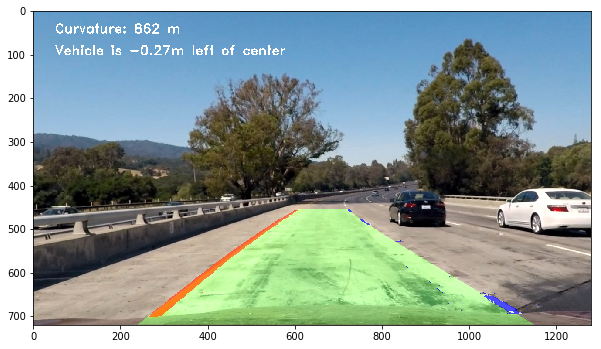

In [22]:
img = np.copy(imgs_undist[idx])

warp_zero = np.zeros_like(img[:,:,0]).astype(np.uint8)
color_warp = np.zeros_like(img).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]))
img_draw = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

# Draw the points detected
left_warp = np.zeros_like(img[:,:,0]).astype(np.uint8)
right_warp = np.zeros_like(img[:,:,0]).astype(np.uint8)
left_warp[lefty, leftx] = 1
right_warp[righty, rightx] = 1
left_unwwarp = cv2.warpPerspective(left_warp, Minv, (left_warp.shape[1], left_warp.shape[0]))
right_unwwarp = cv2.warpPerspective(right_warp, Minv, (right_warp.shape[1], right_warp.shape[0]))
left_unwwarp.nonzero()
img_draw[left_unwwarp.nonzero()[0],left_unwwarp.nonzero()[1],:] = np.int_(0.5*np.array(img_draw[left_unwwarp.nonzero()[0],left_unwwarp.nonzero()[1],:])+ [128,0,0])
img_draw[right_unwwarp.nonzero()[0],right_unwwarp.nonzero()[1],:] = np.int_(0.3*np.array(img_draw[right_unwwarp.nonzero()[0],right_unwwarp.nonzero()[1],:])+ [0,0,178])

#         cv2.putText(img_draw, text="Radius = "+str(int(mean_curverad)) + "(m)", org=(50,50),fontFace=2, fontScale=1, color=(255,255,255), thickness=2)
cv2.putText(img_draw, text='Curvature: {0:} m'.format(int(mean_curverad)) , org=(50,50),fontFace=2, fontScale=1, color=(255,255,255), thickness=2)
cv2.putText(img_draw, text='Vehicle is {0:.2f}m {1} of center'.format(offset_m,offset_dir), org=(50,100),fontFace=2, fontScale=1, color=(255,255,255), thickness=2)
    
plt.imshow(img_draw)
plt.gcf().set_size_inches(10, 8)

## 8. Pipeline

In [25]:
from process import pipeline, calibration, Line
import glob
# Perform Calibration by giving filenames 
cali = calibration('camera_cal/calibration*.jpg')

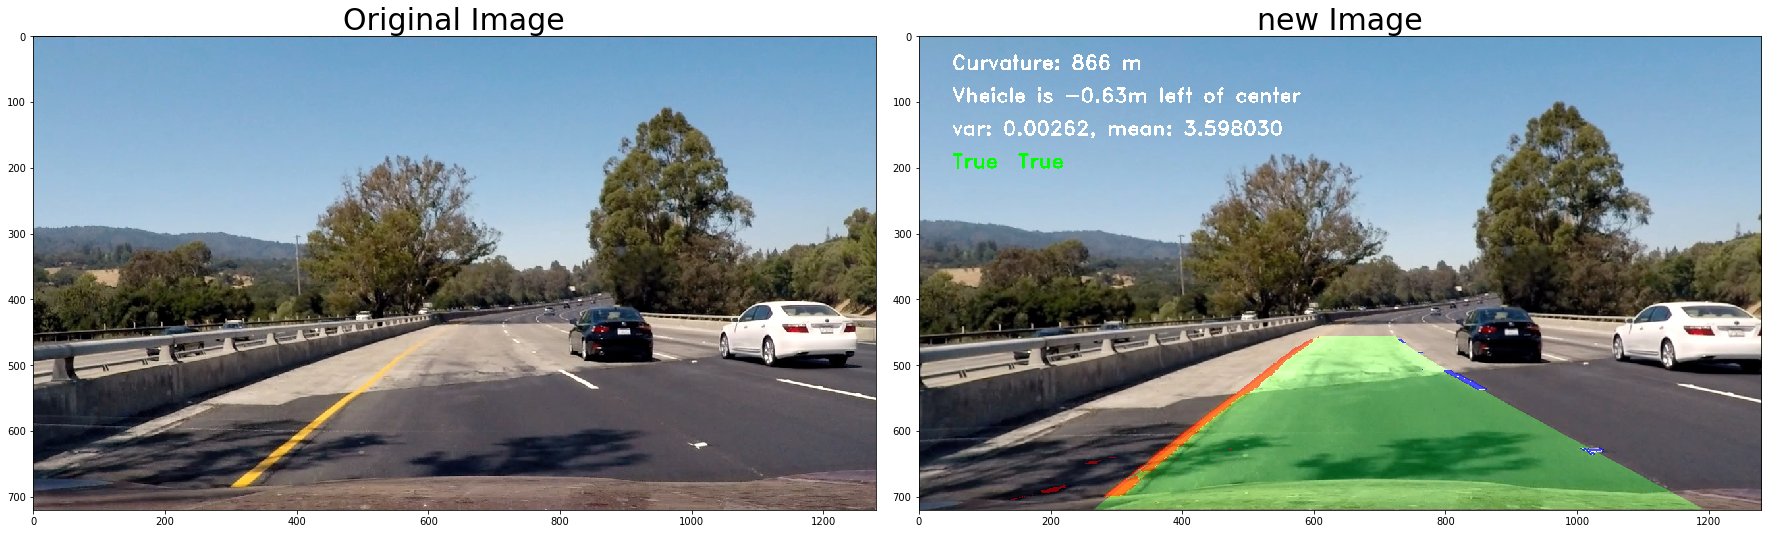

In [26]:
# Create Line object
Line_left = Line()
Line_right = Line()

# Create Pipeline object
pipe = pipeline(cali,Line_left,Line_right)

# Load images
fnames = glob.glob('test_images/*')
imgs_raw = []
for fname in fnames:
    
    img_raw = mpimg.imread(fname)
    imgs_raw.append(img_raw)

idx = 8
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imgs_raw[idx])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(pipe.process_image(imgs_raw[idx]))
# ax2.imshow(pipe.process_image(imgs_raw[idx]),cmap='gray')
ax2.set_title('new Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

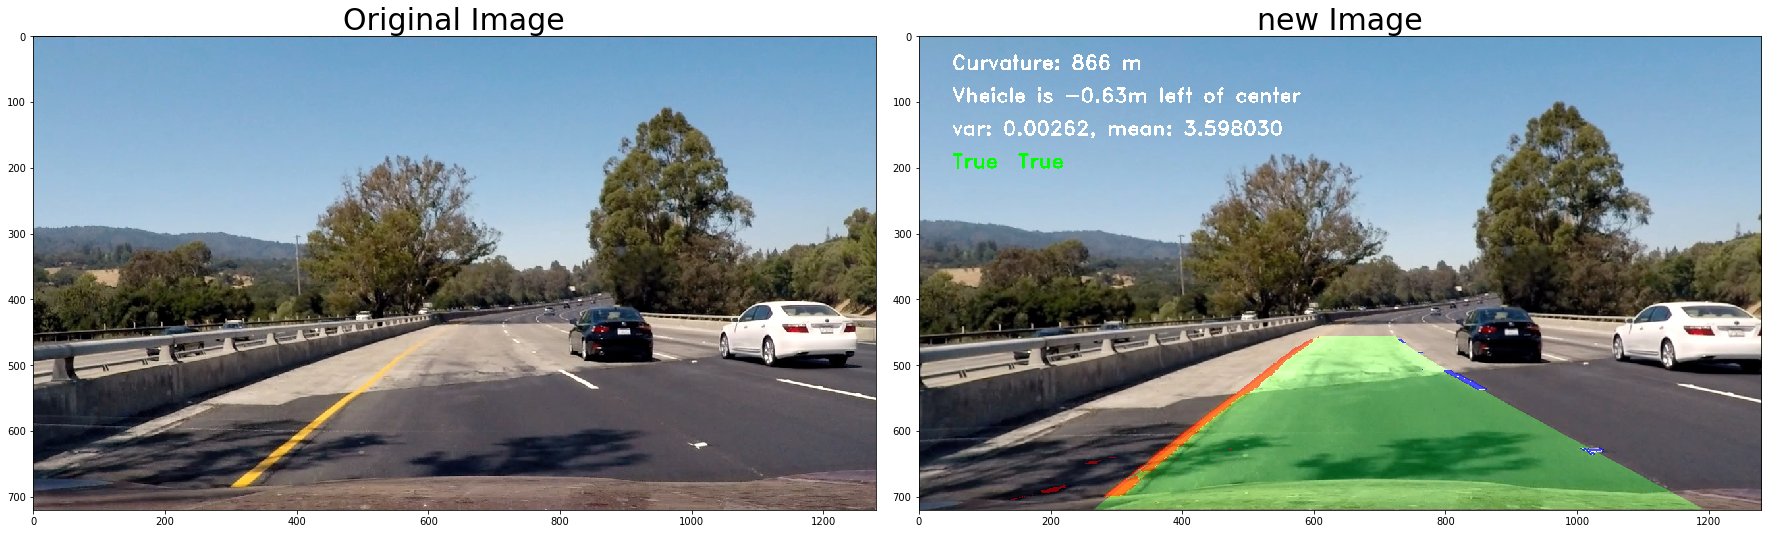

In [27]:
idx = 8
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imgs_raw[idx])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(pipe.process_image(imgs_raw[idx]))
# ax2.imshow(pipe.process_image(imgs_raw[idx]),cmap='gray')
ax2.set_title('new Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Line_left = Line()
Line_right = Line()
pipe = pipeline(cali,Line_left,Line_right)

proj_output = 'output_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(pipe.process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 4min 49s, sys: 6.2 s, total: 4min 56s
Wall time: 2min 18s
